# Cluster Evaluation Metrics #

I would assume that most of you had trouble producing high quality DBSCAN clusters with the Epsilon KNN-Elbow Method. The technique provided a good start for our manual analysis, but it was hard to generate the optimal clusters without some sort of additional techniques. This final assignment in the ML Clustering Section teaches you how to use metrics to evaluate the quality of a model.

We will look at three specific metrics: the Silhouette Coefficient, Calinski-Harabasz Index, and the Davies-Bouldin Index. You'll need to come up with a process for finding and tuning a clustering model. I would expect your process to include code that generates several plots and that it would also require some manual analysis (e.g., thinking).

### References: ###

* [How to Measure Cluster Performance When There Are No Ground Truth by Haitian Wei](https://medium.com/@haataa/how-to-measure-clustering-performances-when-there-are-no-ground-truth-db027e9a871c) is a quick and simple overview of several metrics
* [Cheat Sheet for Implementing 7 Methods for Selecting the Optimal Number of Clusters in Python by Indraneel Baruah](https://towardsdatascience.com/cheat-sheet-to-implementing-7-methods-for-selecting-optimal-number-of-clusters-in-python-898241e1d6ad) has a deeper mathematical explanation of the same metrics.
* [How to Determine the Optimal K for K-Means by Khyati Mahendru](https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb) is a balanced and fairly straightforward explanation of the Silhouette Method but you'll have to wade through the KMeans Elbow Method to get there.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles, make_moons, make_classification, make_blobs
from sklearn.cluster import DBSCAN

In [2]:
# KNN Elbow method for choosing an optimal DBSCAN epsilon
# I've got all of these parameter-choosing helper functions in a module

from sklearn.neighbors import NearestNeighbors
def plot_knn_elbow(X, k_neighbors=4):
    knn = NearestNeighbors(n_neighbors=k_neighbors)
    fit = knn.fit(X)
    distances, _ = fit.kneighbors(X)
    mean_knn = np.mean(distances, axis=1)
    mean_knn = np.sort(mean_knn, axis=0)
    
    plt.figure(figsize=(6,6))
    plt.plot(mean_knn)
    plt.grid()
    plt.ylabel('Epsilon Value');
    plt.draw()

## Generate the Data ##

We will create four datasets with different characteristics using SKLearn. I'd like to generate the same data in class that I used when designing this notebook. Normally, I couldn't do that because the `make_*` functions return random data. But it's possible to choose a certain random state so that you can repeat the same expirment multiple times. I choose a few random states until finding seed values that gave interesting datasets. Good for the classroom bad for real life.

In [3]:
# Blobs should be the easiest
X_blb, y_blb = make_blobs(n_samples=500, n_features=2, cluster_std=0.6, centers=12, random_state=1)

# Circle dataset with an obvious outlier
X_cir, y_cir = make_circles(factor=0.4, noise=0.06, n_samples=500, random_state=16)
X_cir = np.append(X_cir, [[1.5, 1.5]], axis=0)
y_cir = np.append(y_cir, [-1], axis=0)

# Moon dataset with an obvious outlier
X_moo, y_moo = make_moons(noise=0.06, n_samples=500, random_state=16)
X_moo = np.append(X_moo, [[2.0, 1.5]], axis=0)
y_moo = np.append(y_moo, [-1], axis=0)

# Classification dataset will be odd enough without adding any outliers
X_cls, y_cls = make_classification(n_features=2, n_informative=2, n_redundant=0, n_repeated=0, 
                                   n_samples=500, n_classes=3, n_clusters_per_class=1,
                                   random_state=16)

## DBSCAN Parameter Tuning ##

We use *twice-the-feature-count* method to choose the number of `min_samples` for DBSCAN. All of our dataset are 2-D, so this would mean that `min_samples` should be 4. To choose `epsilon`, we plot the KNN Elbow using `k=min_samples` (e.g., 4).

In [ ]:
plot_knn_elbow(X_blb)
plot_knn_elbow(X_cir)
plot_knn_elbow(X_moo)
plot_knn_elbow(X_cls)

## Creating Models with "Optimal" Parameters ##

Now that we've chosen optimal parameters using the `min_samples` rule-of-thumb and the `epsilon` KNN elbow plots, we can create models and look at the accuracy of our clusters. The fit is pretty good with blobs, so-so with moons, worse with the classification, and just plain bad with circles.

Luckily, this was 2-D data, so we can quickly spot the error and start over. If only there were a technique to measure the accuracy of our clusters when the features cannot visualized so easily...

In [ ]:
blb_model = DBSCAN(eps=0.40, min_samples=4)
blb_predict = blb_model.fit_predict(X_blb)

cir_model = DBSCAN(eps=0.09, min_samples=4)
cir_predict = cir_model.fit_predict(X_cir)

moo_model = DBSCAN(eps=0.08, min_samples=4)
moo_predict = moo_model.fit_predict(X_moo)

cls_model = DBSCAN(eps=0.18, min_samples=4)
cls_predict = cls_model.fit_predict(X_cls)

# Show the results
fig, ax = plt.subplots(1, 4, figsize=(20,4))
ax[0].scatter(x=X_blb[:,0], y=X_blb[:,1], c=blb_predict, cmap="tab20")
ax[1].scatter(x=X_cir[:,0], y=X_cir[:,1], c=cir_predict, cmap="tab20")
ax[2].scatter(x=X_moo[:,0], y=X_moo[:,1], c=moo_predict, cmap="tab20")
ax[3].scatter(x=X_cls[:,0], y=X_cls[:,1], c=cls_predict, cmap="tab20")
plt.show()

## Evaluating the Model ##

To be honest, the parameters that we just chose produced clusters that are good quality but not optimal. Yes, you can see the gaps that produce each of the clusters, but the circle and moons only had two clusters. The classification data should have had three clusters. If these parameter tuning rules do not produce the best clusters, are there other techniques to evalute the model and tune the parameters?

There are a variety of techniques to evaluate the overall cluster distribution *after* we have created a model. Each of these techniques measure properties of the model in a slightly different way. We can use these evaluation metrics to help choose better parameters.

To attempt a variety of input parameters and try to balance the scores. Whichever combination of parameters provides the best overall scores is the one that we should try.

**Note:** These strange shaped 'moon' curves tend to be hard to evaluate. In general, concave shaped distributions are harder to handle.

In [6]:
from sklearn import metrics

### Silhoette Coefficient ###

The Silhoette Coefficient compares the average distance within a cluster with the distance between clusters. The worst possible score is -1 (did you really solve the right problem?), a score of zero means that the clusters overlap, and the best possible score is 1 (dense clusters). One of the problems with Silhoette clustering is that its performance is $O(n^2)$.

$$s = \frac{b-a}{max(a, b)}$$

Where $s$ is the Silhoette Coefficient for a single sample, $a$ is the mean distance between the sample and all other samples within the same cluster, and $b$ is the mean distance between the same sample and all other samples in the next closest cluster.

We need to calculate $s$ for every sample and then average them all together to get the Silhoette Coefficient.

### Calinski-Harabasz Index ###

The C-H Index is similar to the Silhoette Coefficient in that it measures the density within a cluster compared to the distance between clusters. Higher scores indicate denser clusters with better separation. The C-H Index performs faster than Silhoette but the calculation itself is more complex.

### Davies-Bouldin Index ###

The D-B Index is different in that it compares the distance between clusters with the size of each cluster. Unlike the other two techniques, a lower score represents better defined clusters.

In [ ]:
model = DBSCAN(eps=0.05, min_samples=4)
predict = model.fit_predict(X_moo)
plt.scatter(x=X_moo[:,0], y=X_moo[:,1], c=predict, cmap="tab20")
print(f"Silhoette -1 to 1 (best):   {metrics.cluster.silhouette_score(X_moo, predict)}")
print(f"CalinskiH (high is better): {metrics.cluster.calinski_harabasz_score(X_moo, predict)}")
print(f"DavisBoul (low is better):  {metrics.cluster.davies_bouldin_score(X_moo, predict)}")
plt.plot()

In [ ]:
model = DBSCAN(eps=0.075, min_samples=4)
predict = model.fit_predict(X_moo)
plt.scatter(x=X_moo[:,0], y=X_moo[:,1], c=predict, cmap="tab20")
print(f"Silhoette -1 to 1 (best):   {metrics.cluster.silhouette_score(X_moo, predict)}")
print(f"CalinskiH (high is better): {metrics.cluster.calinski_harabasz_score(X_moo, predict)}")
print(f"DavisBoul (low is better):  {metrics.cluster.davies_bouldin_score(X_moo, predict)}")
plt.plot()

In [ ]:
model = DBSCAN(eps=0.10, min_samples=4)
predict = model.fit_predict(X_moo)
plt.scatter(x=X_moo[:,0], y=X_moo[:,1], c=predict, cmap="tab20")
print(f"Silhoette -1 to 1 (best):   {metrics.cluster.silhouette_score(X_moo, predict)}")
print(f"CalinskiH (high is better): {metrics.cluster.calinski_harabasz_score(X_moo, predict)}")
print(f"DavisBoul (low is better):  {metrics.cluster.davies_bouldin_score(X_moo, predict)}")
plt.plot()

In [ ]:
model = DBSCAN(eps=0.125, min_samples=4)
predict = model.fit_predict(X_moo)
plt.scatter(x=X_moo[:,0], y=X_moo[:,1], c=predict, cmap="tab20")
print(f"Silhoette -1 to 1 (best):   {metrics.cluster.silhouette_score(X_moo, predict)}")
print(f"CalinskiH (high is better): {metrics.cluster.calinski_harabasz_score(X_moo, predict)}")
print(f"DavisBoul (low is better):  {metrics.cluster.davies_bouldin_score(X_moo, predict)}")
plt.plot()

In [ ]:
model = DBSCAN(eps=0.15, min_samples=4)
predict = model.fit_predict(X_moo)
plt.scatter(x=X_moo[:,0], y=X_moo[:,1], c=predict, cmap="tab20")
print(f"Silhoette -1 to 1 (best):   {metrics.cluster.silhouette_score(X_moo, predict)}")
print(f"CalinskiH (high is better): {metrics.cluster.calinski_harabasz_score(X_moo, predict)}")
print(f"DavisBoul (low is better):  {metrics.cluster.davies_bouldin_score(X_moo, predict)}")
plt.plot()

## Exercise ##

Work in small groups to create a repeatable process that helps you choose optimal parameters for the DBSCAN algorithm. You should use the three clustering metrics shown in this notebook (Silhoette Score, Calniski-Harabasz Score, Davies-Bouldin Score). You may assume domain knowledge of the dataset and also look for a number of clusters that seems reasonable for the dataset. I would expect you to generate several plots and to use some manual analysis (e.g., thinking) to come up with your process. Stick whatever code you come up with in the same module that holds your elbow plot code for KMeans and DBSCAN.

Generate four plots showing your cluster results. My overall results looked like this:

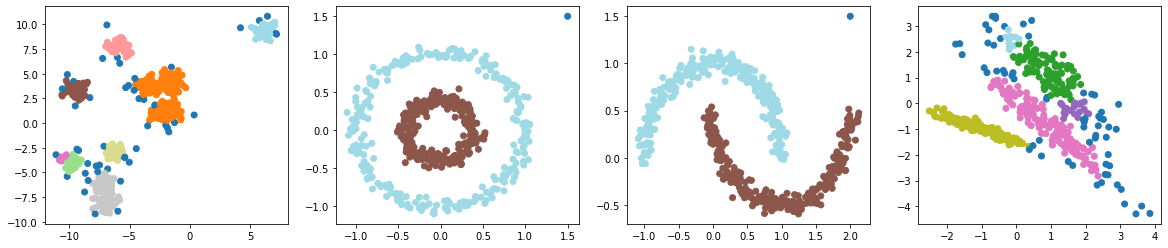